In [2]:
# Imports
%reset -f
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import wandb
import torch.optim as optim
from datasets.CactusDataset import CactusDataset
from models.LeNet5 import LeNet5
from torch.utils.data import ConcatDataset
import os


Image shape: (32, 32, 3)
Image python class<class 'PIL.JpegImagePlugin.JpegImageFile'>
Label: 1
[13136, 4364]


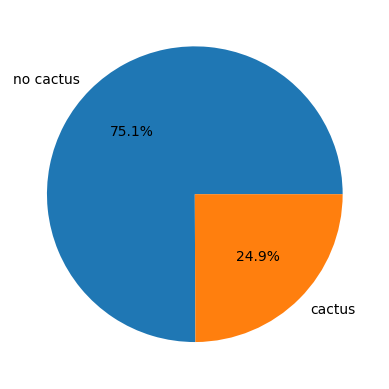

In [3]:
def get_label_distribution(dataset):
    label_counts = {}
    for _, _, label in dataset:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
    sorted_distribution = sorted(label_counts.items(), key=lambda x: x[0], reverse=True)
    # take only the count
    return [x[1] for x in sorted_distribution]

# load data for displaying
dataset = CactusDataset(root_dir='./data/train/train',labels_path='./data/train.csv')
# take the first sample from train_dataloader
_, train_features, train_labels = dataset[0]
image_np = np.array(train_features)
print("Image shape: "+str(image_np.shape))
print("Image python class"+str(type(train_features)))
print("Label: "+str(train_labels))

label_distribution = get_label_distribution(dataset) # they are sorted in ascending order
print(label_distribution)
fig, ax = plt.subplots()
ax.pie(label_distribution, labels=['no cactus','cactus'], autopct='%1.1f%%')
plt.show()

Image python class<class 'torch.Tensor'>
Image shape: torch.Size([3, 32, 32])
Label shape: 1


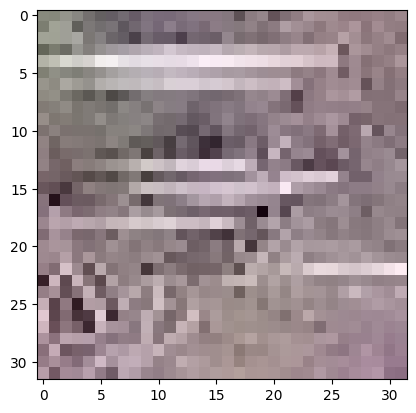

In [4]:
transform_dataset = transforms.Compose([
    transforms.ToTensor()
])

dataset = CactusDataset(
    root_dir="./data/train/train",
    labels_path="./data/train.csv",
    transform=transform_dataset 
)
_, image, label = dataset[0]
print("Image python class" + str(type(image)))
print("Image shape: " + str(image.shape))
print("Label shape: " + str(label))
# show the image
plt.imshow(image.permute(1,2,0))

In [5]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

for i, (img_name, images, labels) in enumerate(dataloader):
    print("Batch number: " + str(i))
    print("Batch image names: " + str(img_name))
    print("Batch images shape: " + str(images.shape))
    print("Batch labels shape: " + str(labels.shape))
    break

Batch number: 0
Batch image names: ('./data/train/train/7511bea55917e31d5148b05f1ac428d3.jpg', './data/train/train/064b90fc86a71fa5850fc0cdc4454b12.jpg', './data/train/train/1d4502c18c722c7d8d9de36dd8ea9616.jpg', './data/train/train/fe1d83c82bd06df2241411b13d427f27.jpg', './data/train/train/07ed82ed790fb29eedc7679dbefda228.jpg', './data/train/train/bd81c59c2b7cc63a79377e04b5fe1e84.jpg', './data/train/train/0d4354b93e62e4517f4d2b4b3ed39d4f.jpg', './data/train/train/eb864dbf18ce0cf3d9f7c99df484e11b.jpg', './data/train/train/f63b4c02b47c6b197c85c1bf339326f6.jpg', './data/train/train/26e0562fa2a019183a15f9e239fd615a.jpg', './data/train/train/81b52ac6b63f943d7f1766794b9fad9c.jpg', './data/train/train/347bc133ae09cc0bf1947ccbeedc4457.jpg', './data/train/train/b2c52b5606a9b7e94e577ba42eba13f1.jpg', './data/train/train/7c87614014353e16653de57a2000d631.jpg', './data/train/train/7d42ce49b1a514536bd0946633d93fc4.jpg', './data/train/train/c5e1c3a0509cfce0183818bdc2e5fd0c.jpg', './data/train/train/

In [6]:
def compute_mean_std(dataset):
    mean = 0.
    std = 0.
    for _, images, _ in dataset:
        mean += images.mean()
        std += images.std()
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

# --------- DATA AUGMENTATION ---------
# filter the dataset to only have no cactus images
dataset = CactusDataset(
    root_dir="./data/train/train",
    labels_path="./data/train.csv",
    transform=transform_dataset
)

no_cactus_dataset = dataset.filter(0)

# create a concatenated dataset with an equal number of cactus and no cactus images
print("Number of no cactus images: " + str(no_cactus_dataset.__len__()))
print("Number of cactus images: " + str(dataset.__len__()-no_cactus_dataset.__len__()))

mean, std = compute_mean_std(ConcatDataset([dataset, no_cactus_dataset, no_cactus_dataset]))
print("Mean: " + str(mean))
print("Std: " + str(std))

merged_dataset_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

dataset=CactusDataset(
    root_dir="./data/train/train",
    labels_path="./data/train.csv",
    transform=merged_dataset_transforms
)

no_cactus_dataset = dataset.filter(0)
dataset_merged = ConcatDataset([dataset,no_cactus_dataset,no_cactus_dataset])

print("Number of no cactus images: " + str(no_cactus_dataset.__len__()))
print("Number of cactus images: " + str(dataset.__len__()-no_cactus_dataset.__len__()))

Number of no cactus images: 4364
Number of cactus images: 13136
Mean: tensor(0.4809)
Std: tensor(0.1019)


In [8]:
# --------- CREATING THE DATA LOADER AND TRAIN/VAL SPLIT ---------
dataset_used = dataset_merged
train_size = int(0.8 * len(dataset_used))
print("Train size: " + str(train_size))
test_size = len(dataset_used) - train_size
print("Test size: " + str(test_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset_used, [train_size, test_size])

# Retrieve the lengths of the datasets
print("dataset length: " + str(len(dataset_used)))


# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,pin_memory=True)
#print a sample
_, image,label=dataset_used.__getitem__(0)
print("Image shape: " + str(image.shape))
print("Label shape: " + str(label))

Train size: 20982
Test size: 5246
dataset length: 26228


Image shape: torch.Size([3, 32, 32])
Label shape: 1



 # Phase 2: defining the model

In [9]:
# !! COMMENT THIS CELL IF NOT USING APPLE SILICON CHIP !!

# Metal Performance Shaders Acceleration
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

model = LeNet5()
model.to(device)
print(model)

tensor([1.], device='mps:0')
LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
log = False

config = {
    "architecture": "LeNet5",
    "dataset": "Cactus",
    "epochs": 2,
    "learning_rate": 0.001,
    "batch_size": 32,
    "momentum": 0.9
}

if log:
    # setting wandb
    wandb.login()

In [21]:
# --------- TRAINING ---------
if log:
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project = "Challenge_1",
    
        # track hyperparameters and run metadata
        config = {
            "architecture": config["architecture"],
            "dataset": config["dataset"],
            "epochs": config["epochs"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "momentum": config["momentum"]
        }
    )
    
    train_dataloader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    if not os.path.exists('./weights/lenet5_model.pth'):
        model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb, freeze=False)
    model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb)
    
    wandb.finish()
else:
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True,pin_memory=True)
    if not os.path.exists('./weights/lenet5_model.pth'):
        model.train_model(train_dataloader, val_dataloader, epochs=config["epochs"], lr=config["learning_rate"], device=device, freeze=False)
    model.train_model(train_dataloader, val_dataloader, epochs=config["epochs"], lr=config["learning_rate"], device=device)

Training on: mps
Epoch: 0 Loss train: 0.09082605696591887
Epoch: 0 Loss val: 0.11883331094754905


KeyboardInterrupt: 